In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image
 
#Setting directories for each task
proj_dir = '/home/mrive301/psb6351_data'
behav_dir = os.path.join(proj_dir, 'dset', 'sub-021', 'func')
loc_behav_files = sorted(glob(behav_dir + '/*loc*.tsv'))
study_behav_files = sorted(glob(behav_dir + '/*study*.tsv'))

#keys for localizer
loc_scene_onset_times = {}
loc_face_onset_times = {}

#Iterating over localizer txt files
for idx, curr_behav_file in enumerate(loc_behav_files):
    loc_scene_onset_times[f'run{idx+1}'] = []
    loc_face_onset_times[f'run{idx+1}'] = []
    
    curr_behav_data = pd.read_csv(curr_behav_file, sep='\t')
    
    #Creating temporary face and scene onset because localizer is a 
        #block design. This allows us to convolve the HRF over face 
        #and scene. We will then grab the first image presentation
    tmp_face_onset = []
    tmp_scene_onset = []
   
    for i, curr_trial_type in enumerate(curr_behav_data['trial_type']):
        if curr_trial_type == 'face':
            tmp_face_onset.append(curr_behav_data['onset'][i])
        elif curr_trial_type == 'scence':
            tmp_scene_onset.append(curr_behav_data['onset'][i])
        # Assigning the first element of the tmp_face_onset list variable to the 
            #dictionary 
        elif curr_trial_type == 'math' and len(tmp_face_onset) == 20:
            loc_face_onset_times[f'run{idx+1}'].append(tmp_face_onset[0])
            tmp_face_onset = []
        elif curr_trial_type == 'math' and len(tmp_scene_onset) == 20:
            loc_scene_onset_times[f'run{idx+1}'].append(tmp_scene_onset[0])
            tmp_scene_onset = []
            
loc_scene_run1_data = ", ".join(map(str, loc_scene_onset_times['run1']))
loc_scene_run2_data = ", ".join(map(str, loc_scene_onset_times['run2']))
loc_face_run1_data = ", ".join(map(str, loc_face_onset_times['run1']))
loc_face_run2_data = ", ".join(map(str, loc_face_onset_times['run2']))

#Setting location to save the timing files
evs_sink_dir = os.path.join(proj_dir, 'derivatives', 'first_lvl', 'sub-021', 'evs')
if not os.path.isdir(evs_sink_dir):
    os.makedirs(evs_sink_dir)
    
#Defining localizer (loc) face and scene evs.
#Each run will have multiple onsets.
loc_scene_evs_file = 'loc_scene_evs.1D'
with open(os.path.join(evs_sink_dir, loc_scene_evs_file), 'wt') as fp:
    fp.writelines([f'{loc_scene_run1_data}\n'])
    fp.writelines([f'{loc_scene_run2_data}\n'])
loc_face_evs_file = 'loc_face_evs.1D'
with open(os.path.join(evs_sink_dir, loc_face_evs_file), 'wt') as fp:
    fp.writelines([f'{loc_face_run1_data}\n'])
    fp.writelines([f'{loc_face_run2_data}\n'])

#Creating dictionary for each event
#Each key will separate the timing files for the
#events of interest and their specific runs.
task_fixb4_c_cond_onset_times = {}
task_fixb4_ic_cond_onset_times = {}
task_remain_events_onset_times = {}
task_facefixb4_bl_onset_times = {}
task_scenefixb4_bl_onset_times = {}

#Iterating over study's behavioral files. 
for idx, curr_behav_file in enumerate(study_behav_files):
    task_fixb4_c_cond_onset_times[f'run{idx+1}'] = []
    task_fixb4_ic_cond_onset_times[f'run{idx+1}'] = []
    task_remain_events_onset_times[f'run{idx+1}'] = []
    task_facefixb4_bl_onset_times[f'run{idx+1}'] = []
    task_scenefixb4_bl_onset_times[f'run{idx+1}'] = []
    
    curr_behav_data = pd.read_csv(curr_behav_file, sep='\t')
    
    #Iterating over trials within runs
    for i, curr_trial_type in enumerate(curr_behav_data['trial_type']):
        # Evaluating whether trial is fixed or conditional 
            #and followed by scene or face
        if 'face' in curr_trial_type or 'scene' in curr_trial_type:
            tmp_fix_onset = curr_behav_data['onset'][i]
            if i > 0:
                #Evaluate whether last trial was a scene or face fixed trial
                    #and grab the current onset time and assign it to the remaining events.
                if 'face' in curr_behav_data['trial_type'][i-1] or 'scene' in curr_behav_data['trial_type'][i-1]:
                    task_remain_events_onset_times[f'run{idx+1}'].append(curr_behav_data['onset'][i])
        #Evaluating whether conditional trial was responded to correctly
        elif curr_trial_type == 'COND' and curr_behav_data['acc'][i] == 1.0:
            if 'face' in curr_behav_data['trial_type'][i-1] or 'scene' in curr_behav_data['trial_type'][i-1]:
                task_fixb4_c_cond_onset_times[f'run{idx+1}'].append(tmp_fix_onset)
            else:
                task_remain_events_onset_times[f'run{idx+1}'].append(curr_behav_data['onset'][i])
        # I do the same for conditional trials that were incorrect.  Trying to separate
        # fix trials that preceded correct from incorrect conditional trials
        elif curr_trial_type == 'COND' and curr_behav_data['acc'][i] == 0.0:
            if 'face' in curr_behav_data['trial_type'][i-1] or 'scene' in curr_behav_data['trial_type'][i-1]:
                task_fixb4_ic_cond_onset_times[f'run{idx+1}'].append(tmp_fix_onset)
            else:
                task_remain_events_onset_times[f'run{idx+1}'].append(curr_behav_data['onset'][i])
        #Similar process as above but for the perceptual baseline trial
        elif curr_trial_type == 'baseline':
            if 'face' in curr_behav_data['trial_type'][i-1]:
                task_facefixb4_bl_onset_times[f'run{idx+1}'].append(tmp_fix_onset)
            else:
                task_remain_events_onset_times[f'run{idx+1}'].append(curr_behav_data['onset'][i])
            if 'scene' in curr_behav_data['trial_type'][i-1]:
                task_scenefixb4_bl_onset_times[f'run{idx+1}'].append(tmp_fix_onset)
            else:
                task_remain_events_onset_times[f'run{idx+1}'].append(curr_behav_data['onset'][i])

#Checking to see if the runs are empty and if they are adding a filler (-1)
for curr_run in ['run1', 'run2', 'run3', 'run4']:
    if len(task_fixb4_c_cond_onset_times[curr_run]) == 0:
        task_fixb4_c_cond_onset_times[curr_run].append(-1)
    if len(task_fixb4_ic_cond_onset_times[curr_run]) == 0:
        task_fixb4_ic_cond_onset_times[curr_run].append(-1)
    if len(task_remain_events_onset_times[curr_run]) == 0:
        task_remain_events_onset_times[curr_run].append(-1)
    if len(task_fixb4_bl_onset_times[curr_run]) == 0:
        task_fixb4_bl_onset_times[curr_run].append(-1)
    if len(task_scenefixb4_bl_onset_times[curr_run]) == 0:
        task_scenefixb4_bl_onset_times[curr_run].append(-1)

#Saving as text file with no square brackets
task_fixb4_c_cond_r1 = ", ".join(map(str, task_fixb4_c_cond_onset_times['run1']))
task_fixb4_c_cond_r2 = ", ".join(map(str, task_fixb4_c_cond_onset_times['run2']))
task_fixb4_c_cond_r3 = ", ".join(map(str, task_fixb4_c_cond_onset_times['run3']))
task_fixb4_c_cond_r4 = ", ".join(map(str, task_fixb4_c_cond_onset_times['run4']))

task_fixb4_ic_cond_r1 = ", ".join(map(str, task_fixb4_ic_cond_onset_times['run1']))
task_fixb4_ic_cond_r2 = ", ".join(map(str, task_fixb4_ic_cond_onset_times['run2']))
task_fixb4_ic_cond_r3 = ", ".join(map(str, task_fixb4_ic_cond_onset_times['run3']))
task_fixb4_ic_cond_r4 = ", ".join(map(str, task_fixb4_ic_cond_onset_times['run4']))

task_remain_evs_cond_r1 = ", ".join(map(str, task_remain_events_onset_times['run1']))
task_remain_evs_cond_r2 = ", ".join(map(str, task_remain_events_onset_times['run2']))
task_remain_evs_cond_r3 = ", ".join(map(str, task_remain_events_onset_times['run3']))
task_remain_evs_cond_r4 = ", ".join(map(str, task_remain_events_onset_times['run4']))

task_facefixb4_bl_cond_r1 = ", ".join(map(str, task_facefixb4_bl_onset_times['run1']))
task_facefixb4_bl_cond_r2 = ", ".join(map(str, task_facefixb4_bl_onset_times['run2']))
task_facefixb4_bl_cond_r3 = ", ".join(map(str, task_facefixb4_bl_onset_times['run3']))
task_facefixb4_bl_cond_r4 = ", ".join(map(str, task_facefixb4_bl_onset_times['run4']))

task_scenefixb4_bl_cond_r1 = ", ".join(map(str, task_scenefixb4_bl_onset_times['run1']))
task_scenefixb4_bl_cond_r2 = ", ".join(map(str, task_scenefixb4_bl_onset_times['run2']))
task_scenefixb4_bl_cond_r3 = ", ".join(map(str, task_scenefixb4_bl_onset_times['run3']))
task_scenefixb4_bl_cond_r4 = ", ".join(map(str, task_scenefixb4_bl_onset_times['run4']))

#Chcking for evs directories
evs_sink_dir = os.path.join(proj_dir, 'derivatives', 'first_lvl', 'sub-021', 'evs')
if not os.path.isdir(evs_sink_dir):
    os.makedirs(evs_sink_dir)

#Creating separate ev files with runs written to each line
task_fixb4_c_cond_evs_file = 'fix_b4_c_cond_evs.1D'
with open(os.path.join(evs_sink_dir, task_fixb4_c_cond_evs_file), 'wt') as fp:
    fp.writelines([f'{task_fixb4_c_cond_r1}\n'])
    fp.writelines([f'{task_fixb4_c_cond_r2}\n'])
    fp.writelines([f'{task_fixb4_c_cond_r3}\n'])
    fp.writelines([f'{task_fixb4_c_cond_r4}\n'])
        
task_fixb4_ic_cond_evs_file = 'fix_b4_ic_cond_evs.1D'
with open(os.path.join(evs_sink_dir, task_fixb4_ic_cond_evs_file), 'wt') as fp:
    fp.writelines([f'{task_fixb4_ic_cond_r1}\n'])
    fp.writelines([f'{task_fixb4_ic_cond_r2}\n'])
    fp.writelines([f'{task_fixb4_ic_cond_r3}\n'])
    fp.writelines([f'{task_fixb4_ic_cond_r4}\n'])
    
task_facefixb4_bl_evs_file = 'facefix_b4_bl_evs.1D'
with open(os.path.join(evs_sink_dir, task_facefixb4_bl_evs_file), 'wt') as fp:
    fp.writelines([f'{task_facefixb4_bl_cond_r1}\n'])
    fp.writelines([f'{task_facefixb4_bl_cond_r2}\n'])
    fp.writelines([f'{task_facefixb4_bl_cond_r3}\n'])
    fp.writelines([f'{task_facefixb4_bl_cond_r4}\n'])
    
task_scenefixb4_bl_evs_file = 'scenefix_b4_bl_evs.1D'
with open(os.path.join(evs_sink_dir, task_scenefixb4_bl_evs_file), 'wt') as fp:
    fp.writelines([f'{task_scenefixb4_bl_cond_r1}\n'])
    fp.writelines([f'{task_scenefixb4_bl_cond_r2}\n'])
    fp.writelines([f'{task_scenefixb4_bl_cond_r3}\n'])
    fp.writelines([f'{task_scenefixb4_bl_cond_r4}\n'])    
    
task_remain_evs_file = 'events_remain_evs.1D'
with open(os.path.join(evs_sink_dir, task_remain_evs_file), 'wt') as fp:
    fp.writelines([f'{task_remain_evs_cond_r1}\n'])
    fp.writelines([f'{task_remain_evs_cond_r2}\n'])
    fp.writelines([f'{task_remain_evs_cond_r3}\n'])
    fp.writelines([f'{task_remain_evs_cond_r4}\n'])

In [4]:
proj_dir = '/home/mrive301/psb6351_data'
motion_dir = '/derivatives/preproc_v2/sub-021/motion'

loc_motion_files = sorted(glob(proj_dir + motion_dir + '/*loc*bold.1D'))
loc_mot_dict = {}
for mot_i, curr_loc_motion_file in enumerate(loc_motion_files):
    loc_mot_dict[f'run{mot_i + 1}'] = np.genfromtxt(curr_loc_motion_file)
    
allruns_loc_motion_data = np.concatenate((loc_mot_dict['run1'], loc_mot_dict['run2']))
np.savetxt(proj_dir + motion_dir + '/allruns_loc_mot_data.1D', allruns_loc_motion_data)

task_motion_files = sorted(glob(proj_dir + motion_dir + '/*study*bold.1D'))
task_mot_dict = {}
for mot_i, curr_task_motion_file in enumerate(task_motion_files):
    task_mot_dict[f'run{mot_i + 1}'] = np.genfromtxt(curr_task_motion_file)
    
allruns_task_motion_data = np.concatenate((task_mot_dict['run1'], task_mot_dict['run2'],
                                           task_mot_dict['run3'], task_mot_dict['run4']))
np.savetxt(proj_dir + motion_dir + '/allruns_task_mot_data.1D', allruns_task_motion_data)

In [7]:
%%bash

3dDeconvolve -nodata 608 1.76 \
-concat '1D: 0 304' \
-ortvec /home/mrive301/psb6351_data/derivatives/preproc_v2/sub-021/motion/allruns_loc_mot_data.1D motion \
-polort A \
-local_times \
-num_stimts 2 \
-stim_times 1 /home/mrive301/psb6351_data/derivatives/first_lvl/sub-021/evs/loc_face_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 1 faces \
-stim_times 2 /home/mrive301/psb6351_data/derivatives/first_lvl/sub-021/evs/loc_scene_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 2 scenes \
-x1D X.loc.xmat.1D -xjpeg X.loc.jpg


Stimulus: faces 
  h[ 0] norm. std. dev. =   0.1917

Stimulus: scenes 
  h[ 0] norm. std. dev. =   0.1927

Stimulus: motion[0] 
  h[ 0] norm. std. dev. =   1.8382

Stimulus: motion[1] 
  h[ 0] norm. std. dev. =   1.0610

Stimulus: motion[2] 
  h[ 0] norm. std. dev. =   1.3996

Stimulus: motion[3] 
  h[ 0] norm. std. dev. =   0.5030

Stimulus: motion[4] 
  h[ 0] norm. std. dev. =   1.7339

Stimulus: motion[5] 
  h[ 0] norm. std. dev. =   0.3531


++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ 3dDeconvolve extending num_stimts from 2 to 8 due to -ortvec
++ 3dDeconvolve: AFNI version=AFNI_20.2.10 (Aug  4 2020) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.76 seconds for -stim_times and -nodata
++ using NT=608 time points for -nodata
++ Imaging duration=535.0 s; Automatic polort=4
++ -stim_times using TR=1.76 s for stimulus timing conversion
++ -stim_times using TR=1.76 s for any -iresp output datasets
++  [you can alter the -iresp TR via the -TR_times option]
++ -stim_times 1 using LOCAL times
++ -stim_times 2 using LOCAL times
++ Number of time points: 608 (no censoring)
 + Number of parameters:  18 [16 baseline ; 2 signal]
++ Wrote matrix image to file X.loc.jpg
++ Wrote matrix values to file X.loc.xmat.1D
++ ----- Signal+Baseline

In [8]:
%%bash

3dDeconvolve -nodata 1420 1.76 \
-concat '1D: 0 355 710 1065' \
-ortvec /home/mrive301/psb6351_data/derivatives/preproc_v2/sub-021/motion/allruns_task_mot_data.1D motion \
-polort A \
-local_times \
-num_stimts 5 \
-stim_times 1 /home/mrive301/psb6351_data/derivatives/first_lvl/sub-021/evs/fix_b4_c_cond_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 1 fx_b4_c_cond \
-stim_times 2 /home/mrive301/psb6351_data/derivatives/first_lvl/sub-021/evs/fix_b4_ic_cond_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 2 fx_b4_ic_cond \
-stim_times 3 /home/mrive301/psb6351_data/derivatives/first_lvl/sub-021/evs/events_remain_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 3 all_remain \
-stim_times 4 /home/mrive301/psb6351_data/derivatives/first_lvl/sub-021/evs/facefix_b4_bl_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 4 facefx_b4_bl \
-stim_times 5 /home/mrive301/psb6351_data/derivatives/first_lvl/sub-021/evs/scenefix_b4_bl_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 4 scenefx_b4_bl \
-x1D X.task.xmat.1D -xjpeg X.task.jpg


Stimulus: fx_b4_c_cond 
  h[ 0] norm. std. dev. =   0.1076

Stimulus: fx_b4_ic_cond 
  h[ 0] norm. std. dev. =   0.1759

Stimulus: all_remain 
  h[ 0] norm. std. dev. =   0.0755

Stimulus: scenefx_b4_bl 
  h[ 0] norm. std. dev. =   0.1273

Stimulus: Stim#5 
  h[ 0] norm. std. dev. =   0.1268

Stimulus: motion[0] 
  h[ 0] norm. std. dev. =   1.1856

Stimulus: motion[1] 
  h[ 0] norm. std. dev. =   0.8875

Stimulus: motion[2] 
  h[ 0] norm. std. dev. =   0.8085

Stimulus: motion[3] 
  h[ 0] norm. std. dev. =   0.5272

Stimulus: motion[4] 
  h[ 0] norm. std. dev. =   1.0894

Stimulus: motion[5] 
  h[ 0] norm. std. dev. =   0.2535


++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
*+ WARNING: -stim_label 4 'scenefx_b4_bl' replacing old label 'facefx_b4_bl'
++ 3dDeconvolve extending num_stimts from 5 to 11 due to -ortvec
*+ WARNING: no -stim_label given for stim #5 ==> label = 'Stim#5'
++ 3dDeconvolve: AFNI version=AFNI_20.2.10 (Aug  4 2020) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.76 seconds for -stim_times and -nodata
++ using NT=1420 time points for -nodata
++ Imaging duration=62

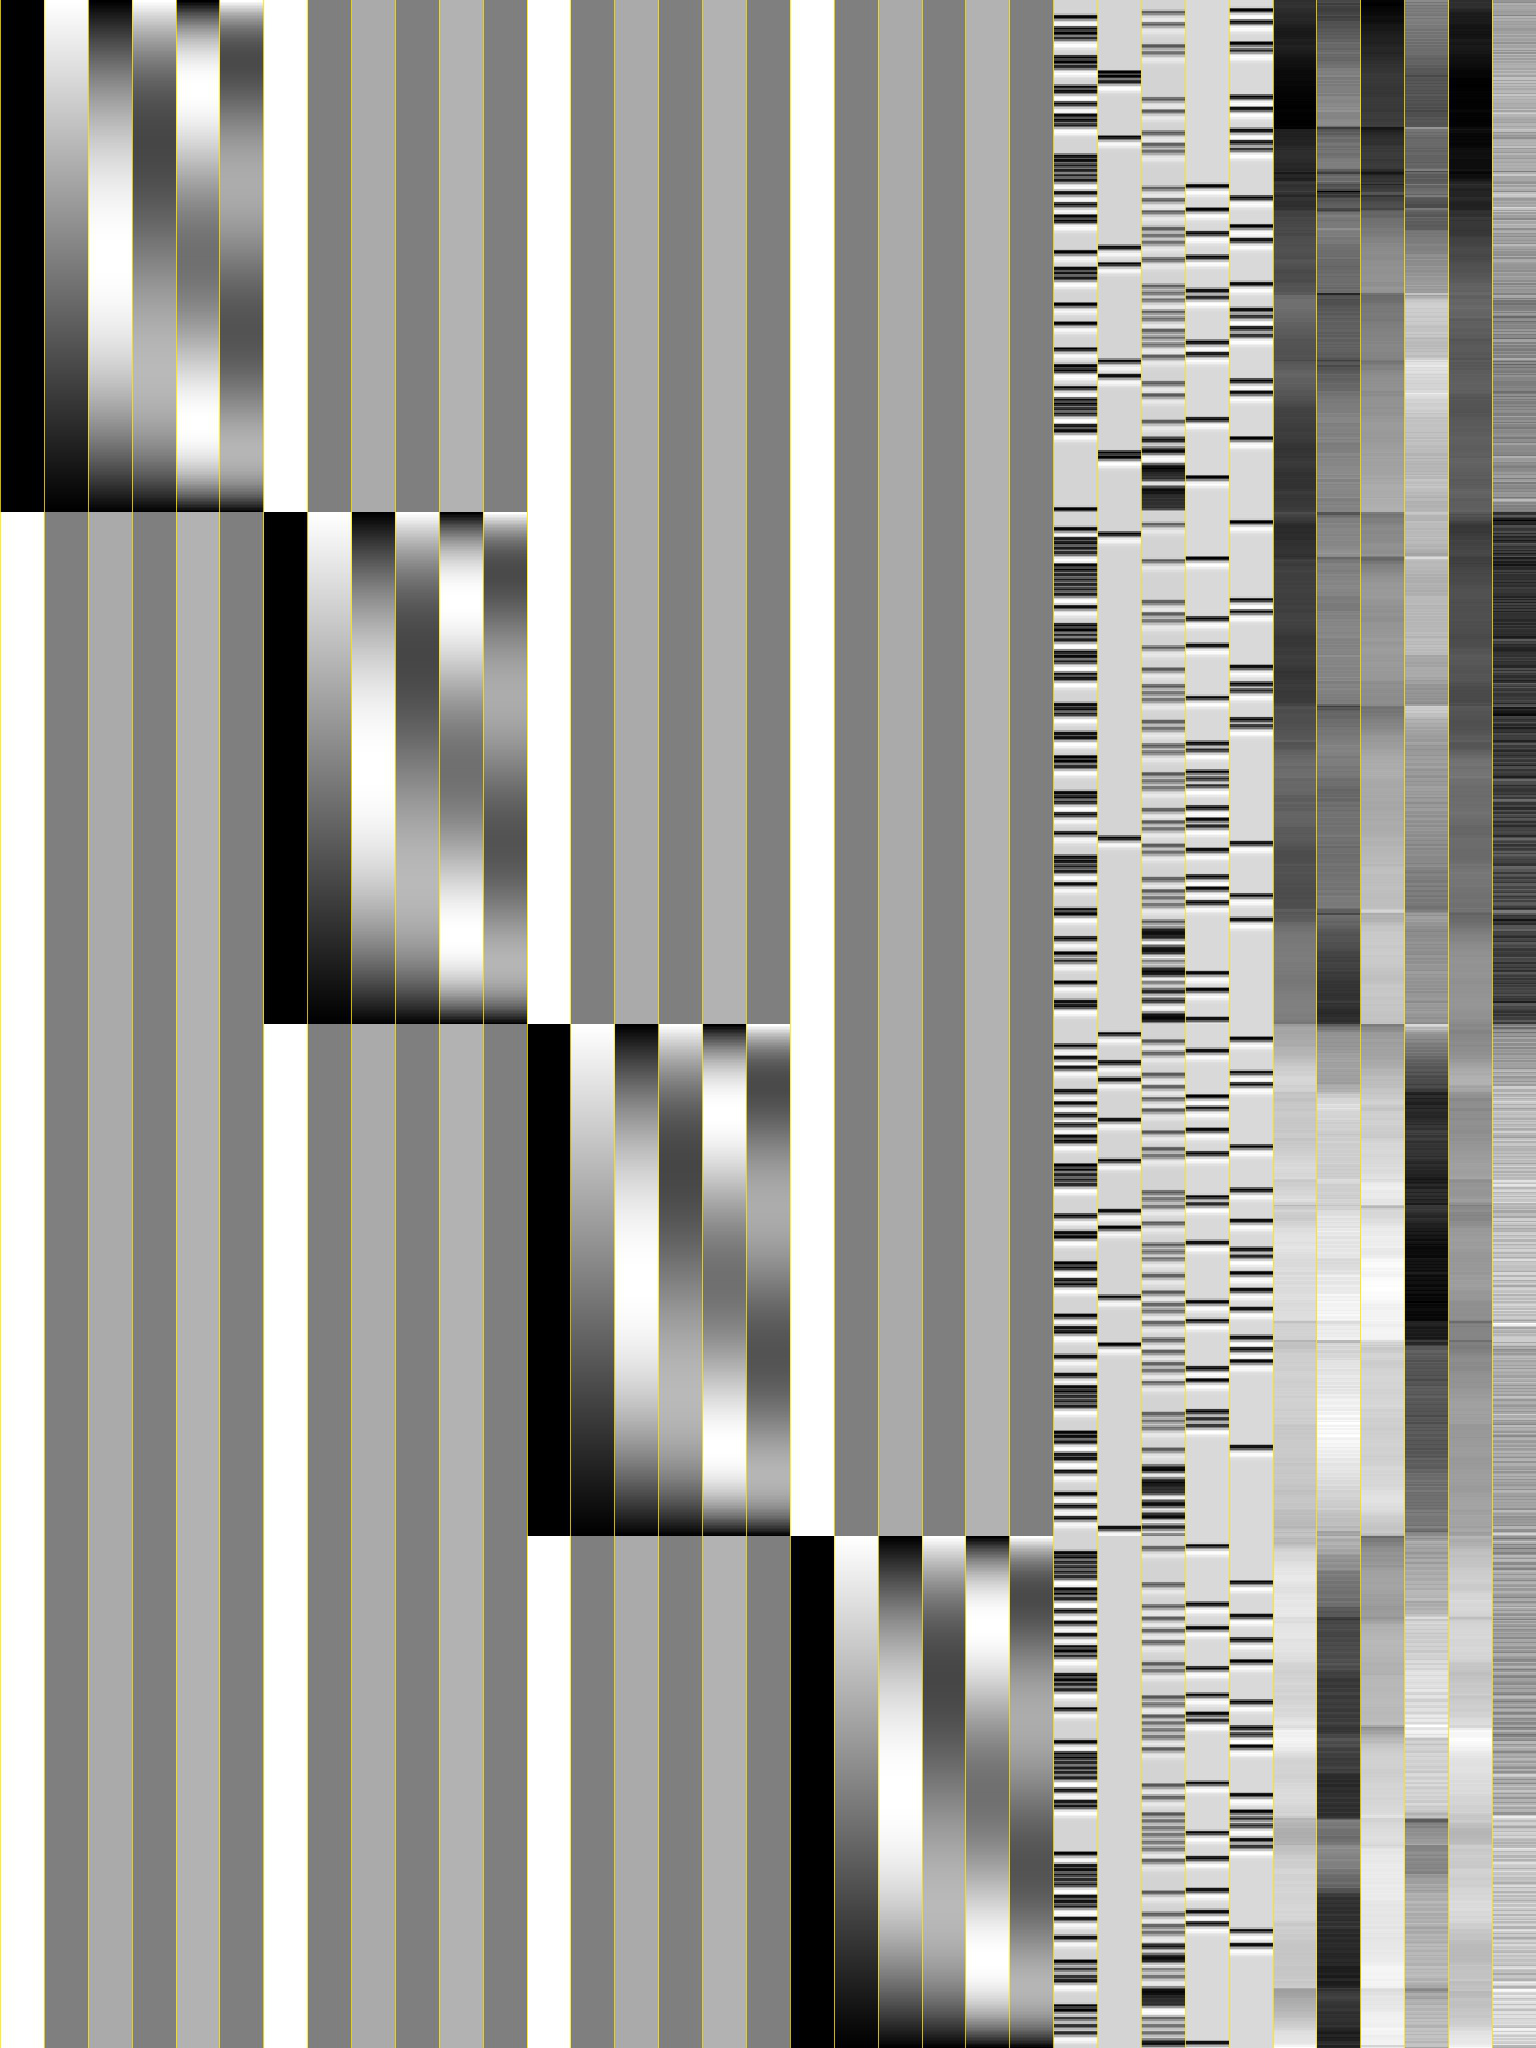

In [9]:
im_task = Image.open(os.path.join(os.getcwd(), 'X.task.jpg'))
im_task

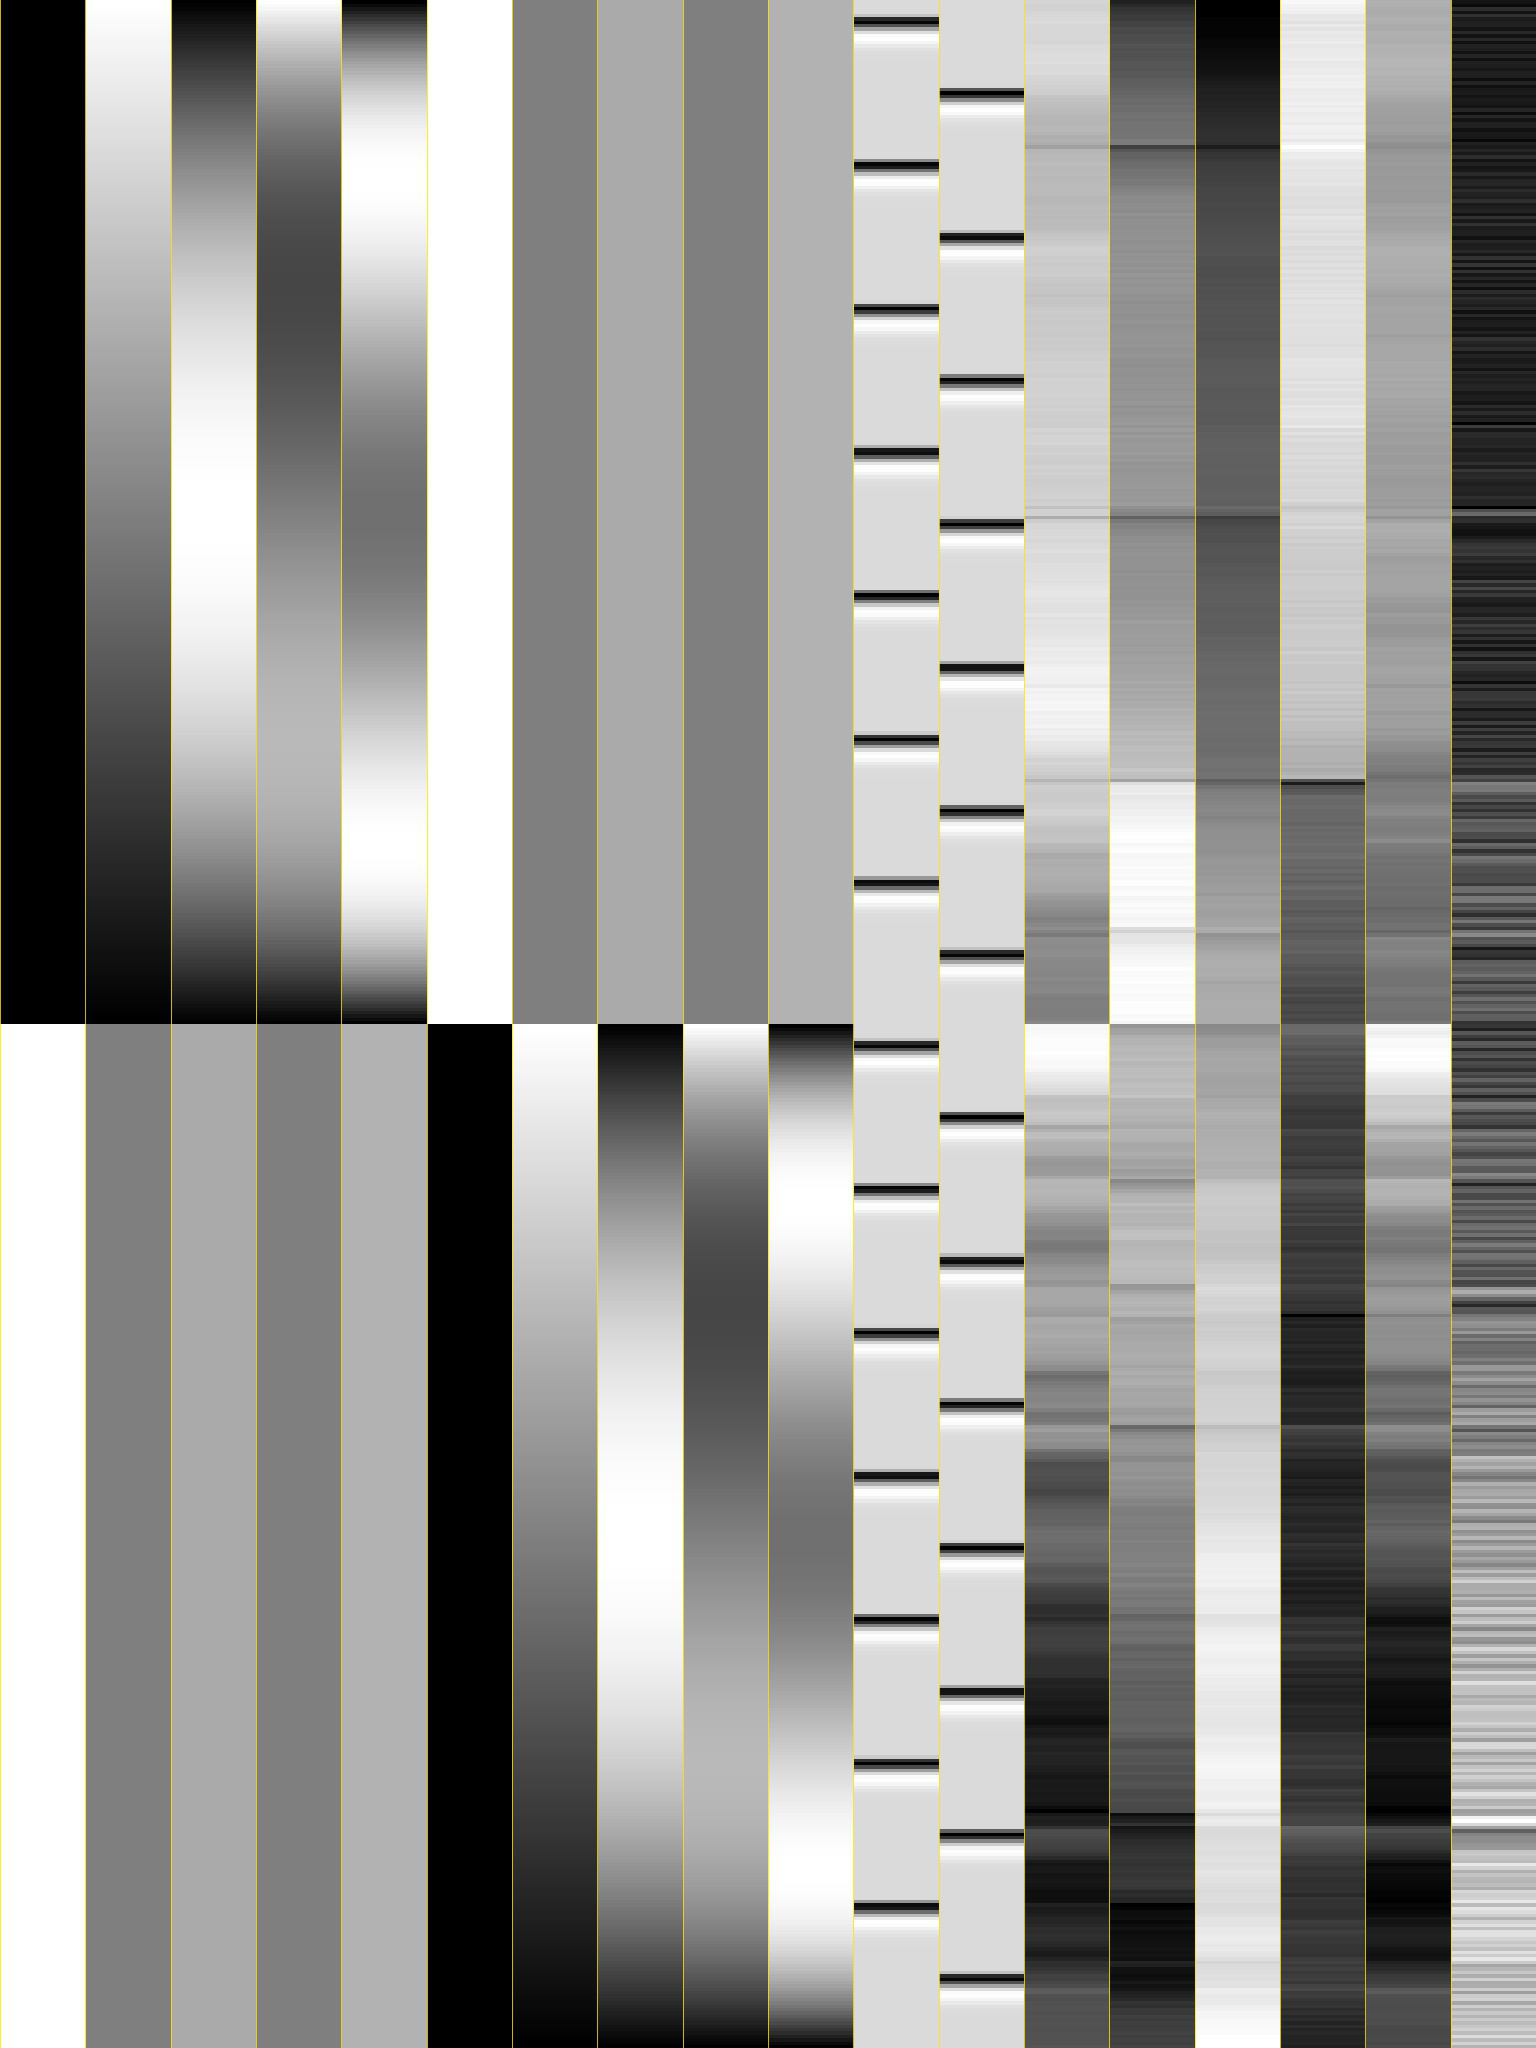

In [10]:
im_loc = Image.open(os.path.join(os.getcwd(), 'X.loc.jpg'))
im_loc